# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
from workspace_utils import active_session
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import time

import maddpg_agent

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677


### 4. Implementing MADDPG

In [7]:
import importlib
import maddpg_agent
import model
importlib.reload(maddpg_agent)
importlib.reload(model)

<module 'model' from '/home/workspace/model.py'>

In [8]:
agent = maddpg_agent.MADDPG(state_size=state_size, action_size=action_size, seed=0, n_agents=2, update_frequency=2, noise_max_timesteps=30000)

In [9]:
def compute_scores(n_episodes=1000, max_t=1000, print_every=200, THRESHOLD=0.50):
    start = time.time()
    seq_start = start
    scores = []
    scores_deque = deque(maxlen=100)
    scores_avg = []

    for i_episode in range(1, n_episodes+1):
        rewards = []
        env_info = env.reset(train_mode=True)[brain_name]    # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)
        
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards_vec = env_info.rewards
            done = env_info.local_done
            # update and train agent with returned information
            agent.step(state, action, rewards_vec, next_state, done)
            state = next_state
            rewards.append(rewards_vec)
            if any(done):
                break

        # compute episode reward (max of all the collected rewards
        episode_reward = np.max(np.sum(np.array(rewards),axis=0))

        scores.append(episode_reward)             # save most recent score to overall score array
        scores_deque.append(episode_reward)       # save most recent score to running window of 100 last scores
        
        current_avg_score = np.mean(scores_deque)
        scores_avg.append(current_avg_score)      # save average of last 100 scores to average score array


        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}, time taken for this sequence: {:.3f} seconds, Total time till now: {:.3f} seconds'.format(
                i_episode, current_avg_score, time.time()-seq_start,  time.time()-start))
            seq_start = time.time()
            agent.save_agents()

        # Check if mean score is higher than THRESHOLD
        if np.mean(scores_deque)>= THRESHOLD:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_agents()
            break
    return scores, scores_avg

In [10]:
with active_session():
    scores, scores_avg = compute_scores(4000, 1000, 200, 0.50)

Episode 200	Average Score: 0.040, time taken for this sequence: 63.066 seconds, Total time till now: 63.066 seconds
Episode 400	Average Score: 0.003, time taken for this sequence: 61.126 seconds, Total time till now: 124.191 seconds
Episode 600	Average Score: 0.034, time taken for this sequence: 69.876 seconds, Total time till now: 194.068 seconds
Episode 800	Average Score: 0.019, time taken for this sequence: 69.907 seconds, Total time till now: 263.975 seconds
Episode 1000	Average Score: 0.054, time taken for this sequence: 82.911 seconds, Total time till now: 346.886 seconds
Episode 1200	Average Score: 0.078, time taken for this sequence: 88.241 seconds, Total time till now: 435.127 seconds
Episode 1400	Average Score: 0.106, time taken for this sequence: 119.562 seconds, Total time till now: 554.689 seconds
Episode 1600	Average Score: 0.098, time taken for this sequence: 121.822 seconds, Total time till now: 676.511 seconds
Episode 1800	Average Score: 0.115, time taken for this sequ

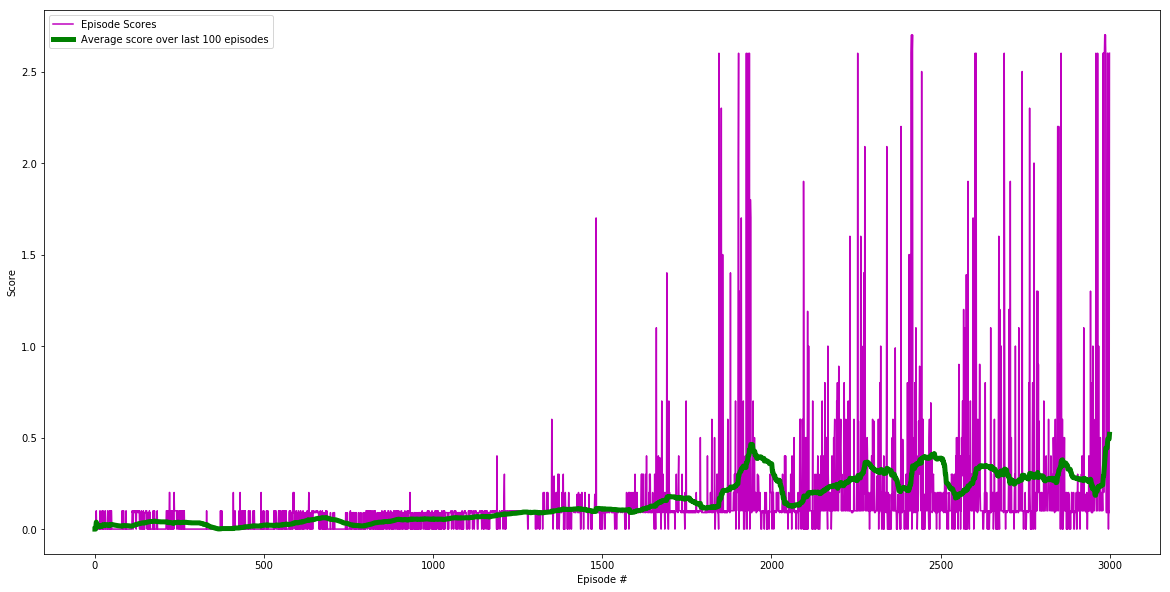

In [14]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,'m',label='Episode Scores')
plt.plot(np.arange(1, len(scores)+1), scores_avg,'g',\
         linewidth=5,label='Average score over last 100 episodes')
plt.ylabel('Score')
plt.xlabel('Episode #')
ax.legend(loc='best')
plt.savefig('Scores.png')
plt.show()

In [12]:
env.close()

When finished, you can close the environment.